In [ ]:
!pip install -q diffusers transformers accelerate opencv-python controlnet-aux

# ControlNet

**ControlNet** is a type of model for controling image diffusion models by conditioning the model with an additional input image.

A ControlNet model has two sets of weights (or blocks) connected by a zero-convolution layer:
* a *lcoked copy* keeps everything a large pretrained diffusion model has learned
* a *trainable copy* is trained on the additional conditioning input

Since the locked copy preeserves the pretrained model, training and implementing a ControlNet on a new conditioning input is as fast as finetuning any other model because we are not training the model from scratch.

## Text-to-image

Prepare a canny image

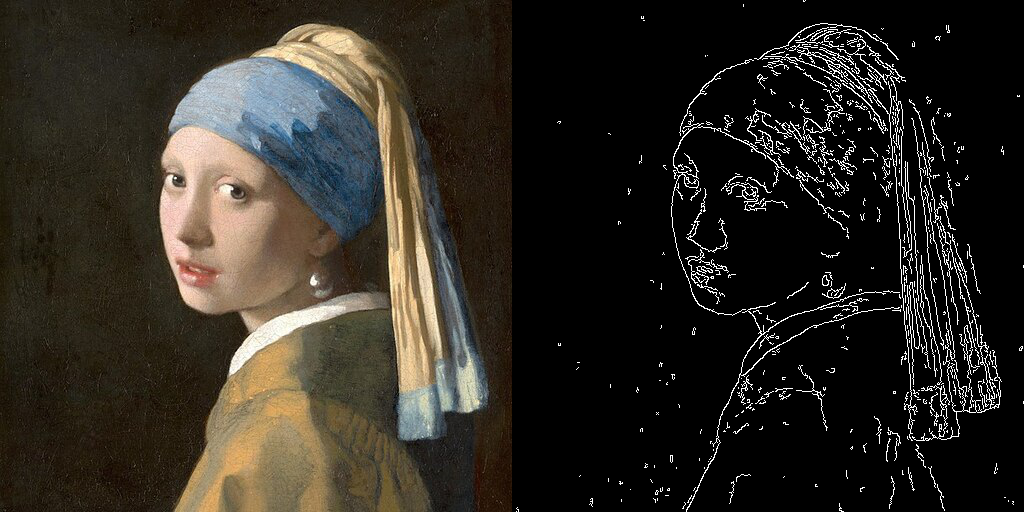

In [5]:
from diffusers.utils import load_image, make_image_grid
from PIL import Image
import cv2
import numpy as np

original_image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image = np.array(original_image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
make_image_grid([original_image, canny_image], rows=1, cols=2)

Load a ControlNet model conditioned on canny edge detection and pass it to the `StableDiffusionControlNetPipeline`. Use the faster `UniPCMultistepScheduler` and enable model offloading to speed up inference and reduce memory usage.

In [4]:
from diffusers import StableDiffusionControlNetPipeline, UniPCMultistepScheduler, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained(
    'lllyasviel/sd-controlnet-canny',
    torch_dtype=torch.float16,
    use_safetensors=True
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

(512, 512)

In [ ]:
output = pipe(
    'the mona lisa',
    image=canny_image,
).images[0]
make_image_grid([original_image, canny_image, output], rows=1, cols=3)

## Image-to-image

In [ ]:
import torch
import numpy as np
from transformers import pipeline
from diffusers.utils import load_image, make_image_grid

depth_estimator = pipeline('depth-estimation')

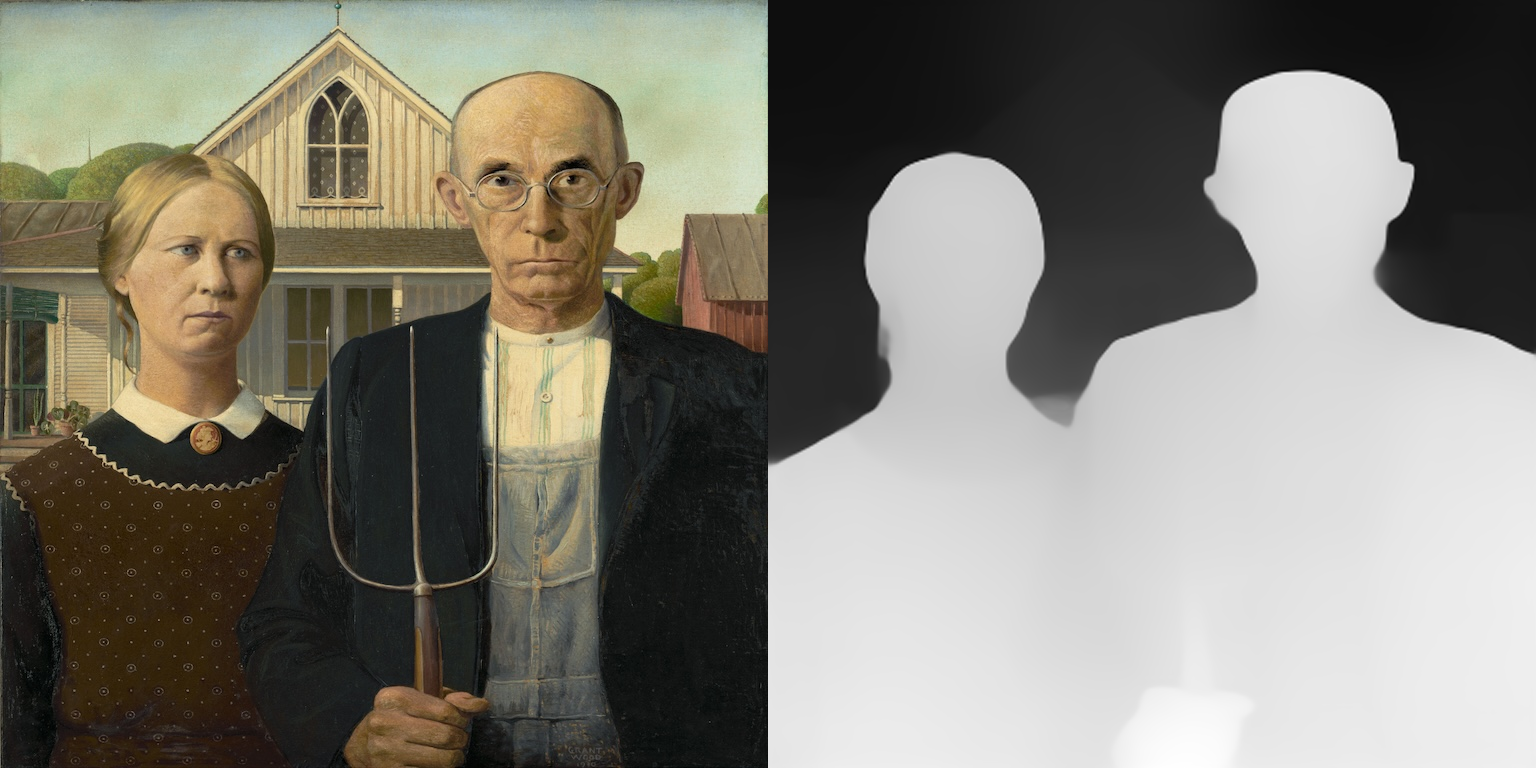

In [26]:
from PIL import Image

image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet-img2img.jpg"
)

def get_depth_map(image, depth_estimator):
    img = depth_estimator(image)['depth']
    img = np.array(img)
    img = img[:, :, None]
    img = np.concatenate([img, img, img], axis=2)
    detected_map = torch.from_numpy(img).float() / 255.
    depth_map = detected_map.permute(2, 0, 1)

    return depth_map

depth_map = get_depth_map(image, depth_estimator)
make_image_grid([
        image,
        Image.fromarray((depth_map.permute(1, 2, 0) * 255).type(torch.uint8).numpy())
    ],
                rows=1,
                cols=2)

In [ ]:
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained(
    'lllyasviel/control_v11f1p_sd15_depth',
    torch_dtype=torch.float16,
    use_safetensors=True
)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

In [ ]:
output = pipe(
    ';lego batman and robin',
    image=image,
    control_image=depth_map,
).images[0]
make_image_grid([image, output], rows=1, cols=2)

## Inpainting

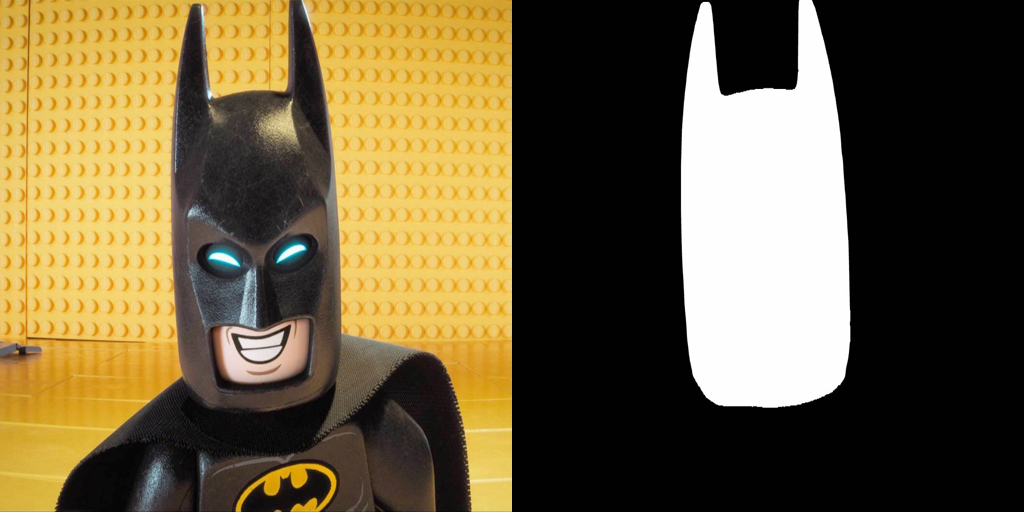

In [27]:
from diffusers.utils import load_image, make_image_grid

init_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet-inpaint.jpg"
)
init_image = init_image.resize((512, 512))

mask_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet-inpaint-mask.jpg"
)
mask_image = mask_image.resize((512, 512))

make_image_grid([init_image, mask_image], rows=1, cols=2)

In [32]:
import numpy as np
import torch

def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert('RGB')).astype(np.float32) / 255.
    image_mask = np.array(image_mask.convert('L')).astype(np.float32) / 255.

    assert image.shape[0:1] == image_mask.shape[0:1]
    image[image_mask > 0.5] = -1.0   # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1 ,2)
    image = torch.from_numpy(image)
    return image

control_image = make_inpaint_condition(init_image, mask_image)
control_image.shape

torch.Size([1, 3, 512, 512])

In [ ]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler

controlnet = ControlNetModel.from_pretrained(
    'lllyasviel/control_v11p_sd15_inpaint',
    torch_dtype=torch.float16,
    use_safetensors=True
)

pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

In [ ]:
output = pipe(
    "corgi face with large ears, detailed, pixar, animated, disney",
    num_inference_steps=20,
    eta=1.0,
    image=init_image,
    mask_image=mask_image,
    control_image=control_image,
).images[0]
make_image_grid([init_image, mask_image, output], rows=1, cols=3)

## Guess mode

Guess mode does not require supplying a prompt to a ControlNet at all. This forces the ControlNet encoder to do its best to "guess" the contents of the input control map.

Set `guess_mode=True` in the pipeline, and set the `guidance_scale` value between 3 and 5.

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image, make_image_grid
import numpy as np
import torch
from PIL import Image
import cv2

controlnet = ControlNetModel.from_pretrained(
    'lllyasviel/sd-controlnet-canny',
    torch_dtype=torch.float16,
    use_safetensors=True
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True
).to('cuda')

In [ ]:
original_image = load_image("https://huggingface.co/takuma104/controlnet_dev/resolve/main/bird_512x512.png")
image = np.array(original_image)

low_thre = 100
high_thre = 200
image = cv2.Canny(image, low_thre, high_thre)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

output = pipe(
    "",
    image=canny_image,
    guess_mode=True,
    guidance_scale=3.0,
).images[0]
make_image_grid([original_image, canny_image, output], rows=1, cols=3)

## ControlNet with Stable Diffusion XL

In [ ]:
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image, make_image_grid
from PIL import Image
import cv2
import numpy as np
import torch

controlnet = ControlNetModel.from_pretrained(
    'diffusers/controlnet-canny-sdxl-1.0',
    torch_dtype=torch.float16,
    use_safetensors=True
)

vae = AutoencoderKL.from_pretrained(
    'madebyollin/sdxl-vae-fp16-fix',
    torch_dtype=torch.float16,
    use_safetensors=True
)

pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    'stabilityai/stable-diffusion-xl-base-1.0',
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True
)
pipe.enable_model_cpu_offload()

In [ ]:
original_image = load_image(
    "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png"
)

image = np.array(original_image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
make_image_grid([original_image, canny_image], rows=1, cols=2)

The `controlnet_conditioning_scale` parameter determines how much weight to assign to the conditioning inputs. A value of 0.5 is recommended for good generalization.

In [ ]:
prompt = "aerial view, a futuristic research complex in a bright foggy jungle, hard lighting"
negative_prompt = 'low quality, bad quality, sketches'

image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image=canny_image,
    controlnet_conditioning_scale=0.5,
)
make_image_grid([original_image, canny_image, image], rows=1, cols=3)

We can also use `StableDiffusionXLControlNetPipeline` in guess mode as well:

In [ ]:
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image, make_image_grid
import numpy as np
import torch
import cv2
from PIL import Image

controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True
)
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    torch_dtype=torch.float16,
    use_safetensors=True
)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True
)
pipe.enable_model_cpu_offload()

In [ ]:
original_image = load_image(
    "https://hf.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png"
)

image = np.array(original_image)
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

prompt = "aerial view, a futuristic research complex in a bright foggy jungle, hard lighting"
negative_prompt = "low quality, bad quality, sketches"

image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=0.5,
    image=canny_image,
    guess_mode=True,  # enable guess mode
).images[0]
make_image_grid([original_image, canny_image, image], rows=1, cols=3)

We can use a refiner model with `StableDiffusionXLControlNetPipeline` to improve image quality.

## MultiControlNet

Composing multiple ControlNet conditionings from different image inputs is useful but we need to make sure to
1. mask conditionings such that they do not overlap
2. experiment with the `controlnet_conditioning_scale` to determine how much weight to assign to each conditioningg input.

In [2]:
from diffusers.utils import load_image, make_image_grid
from PIL import Image
import numpy as np
import cv2

original_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/landscape.png"
)
image = np.array(original_image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image.shape

(512, 512)

In [3]:
# Zero out middle collumns of image where pose will be overlaid
zero_start = image.shape[1] // 4
zero_end = zero_start + image.shape[1] // 2
image[:, zero_start:zero_end] = 0

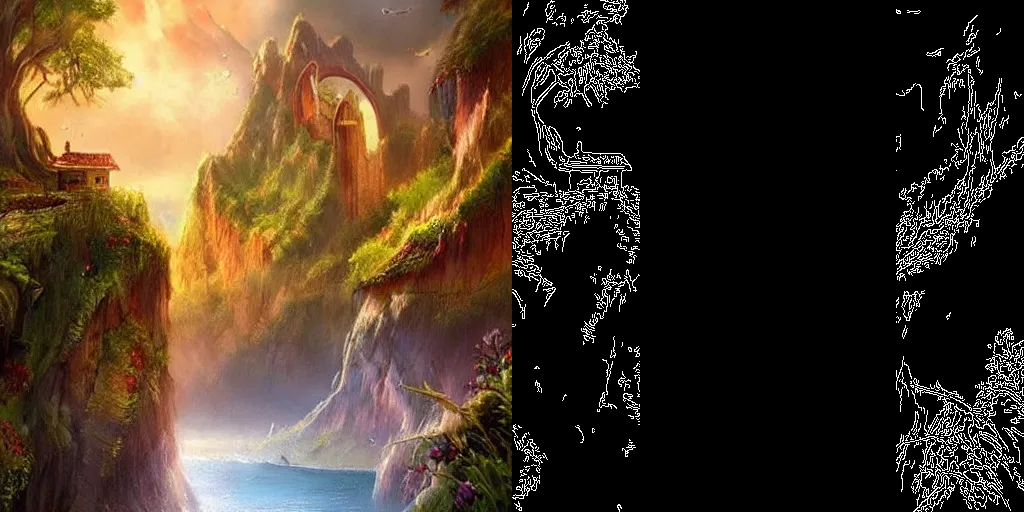

In [4]:
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
make_image_grid([original_image, canny_image], rows=1, cols=2)

In [ ]:
# prepare the human pose
from controlnet_aux import OpenposeDetector

openpose = OpenposeDetector.from_pretrained('lllysaviel/ControlNet')
original_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

openpose_image = openpose(original_image)
make_image_grid([original_image, openpose_image], rows=1, cols=2)

In [ ]:
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL, UniPCMultistepScheduler
import torch

controlnets = [
    ControlNetModel.from_pretrained(
        "thibaud/controlnet-openpose-sdxl-1.0",
        torch_dtype=torch.float16
    ),
    ControlNetModel.from_pretrained(
        "diffusers/controlnet-canny-sdxl-1.0",
        torch_dtype=torch.float16,
        use_safetensors=True
    ),
]

vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    torch_dtype=torch.float16,
    use_safetensors=True
)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnets,
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

In [ ]:
prompt = "a giant standing in a fantasy landscape, best quality"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"

generator = torch.manual_seed(111)

images = [
    openpose_image.resize((1024, 1024)),
    canny_image.resize((1024, 1024))
]

images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image=images,
    num_inference_steps=25,
    generator=generator,
    num_images_per_prompt=3,
    controlnet_conditioning_scale=[1.0, 0.8],
)
make_image_grid(
    [
        original_image,
        openpose_image,
        canny_image,
        images[0].resize((512, 512)),
        images[1].resize((512, 512)),
        images[2].resize((512, 512)),
    ],
    rows=2,
    cols=3,
)